# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

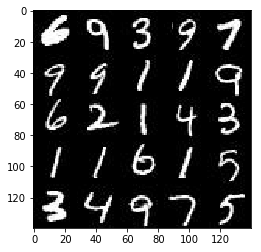

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

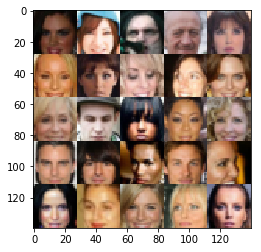

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return real_inputs, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/shinto/anaconda3/envs/py3xgb/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/hom

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        some_factor = 0.2
        h1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        h1 = tf.nn.relu(h1)
        
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum( 0.2 * h2, h2)
        
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum( 0.2 * h3, h3)
        
        h4 = tf.reshape(h3, [-1, 4*4*256])
        logits = tf.layers.dense(h4, 1, activation=None)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train) as g_scope:
        alpha = 0.2
        
        h1 = tf.layers.dense(z, units=2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d_transpose(h1, filters=256, kernel_size=5, strides=2, padding='valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                           labels=tf.ones_like(disc_model_real)*(1-0.1)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                           labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                     labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    print(data_shape)
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(gen_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                i += 1
                if i % 10 == 0:
                    train_loss_disc = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: batch_z})
                    print('Epoch %d/%d Discriminator loss %.4f Generator loss %.4f' % (epoch_i, epoch_count,
                                                                                       train_loss_disc, train_loss_gen ))
                if i % 100 == 0:
                    show_generator_output(sess, 50, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 0/2 Discriminator loss 3.1249 Generator loss 0.1295
Epoch 0/2 Discriminator loss 0.6653 Generator loss 3.4928
Epoch 0/2 Discriminator loss 0.8132 Generator loss 15.5980
Epoch 0/2 Discriminator loss 0.7023 Generator loss 2.7965
Epoch 0/2 Discriminator loss 0.4422 Generator loss 4.0888
Epoch 0/2 Discriminator loss 1.3840 Generator loss 0.8082
Epoch 0/2 Discriminator loss 0.5688 Generator loss 2.4266
Epoch 0/2 Discriminator loss 0.8988 Generator loss 1.2867
Epoch 0/2 Discriminator loss 0.5139 Generator loss 4.2767
Epoch 0/2 Discriminator loss 0.5784 Generator loss 5.5474


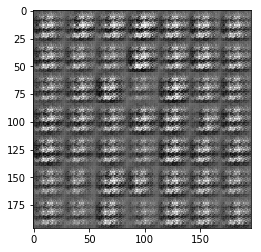

Epoch 0/2 Discriminator loss 0.5291 Generator loss 2.3672
Epoch 0/2 Discriminator loss 0.4761 Generator loss 4.9330
Epoch 0/2 Discriminator loss 0.5165 Generator loss 2.9760
Epoch 0/2 Discriminator loss 0.4993 Generator loss 2.7385
Epoch 0/2 Discriminator loss 0.9792 Generator loss 1.1041
Epoch 0/2 Discriminator loss 0.4780 Generator loss 3.7702
Epoch 0/2 Discriminator loss 0.4662 Generator loss 2.9249
Epoch 0/2 Discriminator loss 0.4782 Generator loss 2.7676
Epoch 0/2 Discriminator loss 0.6202 Generator loss 1.7522
Epoch 0/2 Discriminator loss 0.5739 Generator loss 4.7144


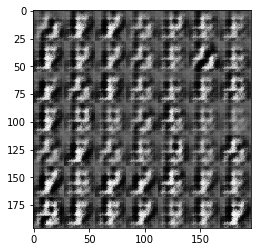

Epoch 0/2 Discriminator loss 0.5388 Generator loss 3.1454
Epoch 0/2 Discriminator loss 0.4827 Generator loss 2.8125
Epoch 0/2 Discriminator loss 0.5211 Generator loss 3.5258
Epoch 0/2 Discriminator loss 0.5476 Generator loss 3.1391
Epoch 0/2 Discriminator loss 0.4734 Generator loss 2.8928
Epoch 0/2 Discriminator loss 0.5212 Generator loss 2.6974
Epoch 0/2 Discriminator loss 1.0970 Generator loss 1.0652
Epoch 0/2 Discriminator loss 0.6809 Generator loss 2.4338
Epoch 0/2 Discriminator loss 0.6335 Generator loss 2.8660
Epoch 0/2 Discriminator loss 0.6835 Generator loss 3.1388


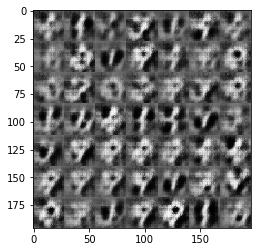

Epoch 0/2 Discriminator loss 0.6575 Generator loss 1.8250
Epoch 0/2 Discriminator loss 0.4491 Generator loss 3.4323
Epoch 0/2 Discriminator loss 1.0452 Generator loss 1.0332
Epoch 0/2 Discriminator loss 1.0708 Generator loss 3.8110
Epoch 0/2 Discriminator loss 0.6408 Generator loss 2.1738
Epoch 0/2 Discriminator loss 1.1426 Generator loss 3.6661
Epoch 0/2 Discriminator loss 0.7539 Generator loss 1.5867
Epoch 0/2 Discriminator loss 0.6656 Generator loss 2.0696
Epoch 0/2 Discriminator loss 0.6428 Generator loss 3.1009
Epoch 0/2 Discriminator loss 0.7156 Generator loss 1.7219


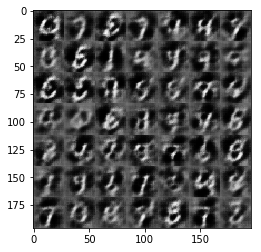

Epoch 0/2 Discriminator loss 0.7729 Generator loss 1.6660
Epoch 0/2 Discriminator loss 0.7470 Generator loss 2.5946
Epoch 0/2 Discriminator loss 0.7463 Generator loss 2.3488
Epoch 0/2 Discriminator loss 0.8328 Generator loss 2.2539
Epoch 0/2 Discriminator loss 0.7000 Generator loss 2.1638
Epoch 0/2 Discriminator loss 0.8577 Generator loss 1.8400
Epoch 0/2 Discriminator loss 0.7234 Generator loss 1.5765
Epoch 0/2 Discriminator loss 0.8403 Generator loss 1.4931
Epoch 0/2 Discriminator loss 0.8214 Generator loss 1.5227
Epoch 0/2 Discriminator loss 1.0499 Generator loss 0.9821


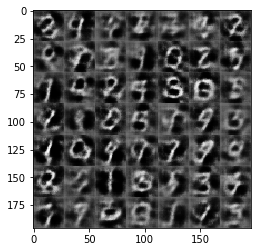

Epoch 0/2 Discriminator loss 0.9675 Generator loss 1.2128
Epoch 0/2 Discriminator loss 0.8185 Generator loss 1.5124
Epoch 0/2 Discriminator loss 0.8946 Generator loss 2.1662
Epoch 0/2 Discriminator loss 0.9036 Generator loss 1.2470
Epoch 0/2 Discriminator loss 1.3553 Generator loss 0.6149
Epoch 0/2 Discriminator loss 0.8858 Generator loss 1.9740
Epoch 0/2 Discriminator loss 1.0699 Generator loss 2.3218
Epoch 0/2 Discriminator loss 1.0164 Generator loss 1.8559
Epoch 0/2 Discriminator loss 0.8464 Generator loss 1.7897
Epoch 0/2 Discriminator loss 0.7045 Generator loss 1.9086


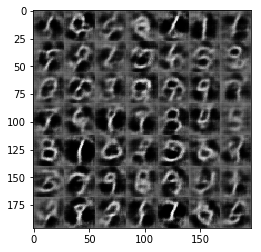

Epoch 0/2 Discriminator loss 0.7334 Generator loss 2.3195
Epoch 0/2 Discriminator loss 0.9733 Generator loss 1.1142
Epoch 0/2 Discriminator loss 0.8772 Generator loss 2.2407
Epoch 0/2 Discriminator loss 1.0151 Generator loss 0.9110
Epoch 0/2 Discriminator loss 0.8133 Generator loss 1.7107
Epoch 0/2 Discriminator loss 0.8415 Generator loss 1.9756
Epoch 0/2 Discriminator loss 0.9992 Generator loss 2.1151
Epoch 0/2 Discriminator loss 1.2675 Generator loss 2.6915
Epoch 0/2 Discriminator loss 0.7507 Generator loss 1.6248
Epoch 0/2 Discriminator loss 0.8145 Generator loss 1.9854


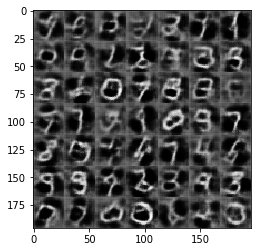

Epoch 0/2 Discriminator loss 0.9264 Generator loss 1.1864
Epoch 0/2 Discriminator loss 1.2369 Generator loss 0.6810
Epoch 0/2 Discriminator loss 0.9345 Generator loss 1.1625
Epoch 0/2 Discriminator loss 0.9046 Generator loss 1.8016
Epoch 0/2 Discriminator loss 0.9978 Generator loss 1.7474
Epoch 0/2 Discriminator loss 1.1287 Generator loss 0.7367
Epoch 0/2 Discriminator loss 0.9114 Generator loss 1.2064
Epoch 0/2 Discriminator loss 1.1596 Generator loss 2.4774
Epoch 0/2 Discriminator loss 0.8542 Generator loss 1.9274
Epoch 0/2 Discriminator loss 0.9228 Generator loss 2.3541


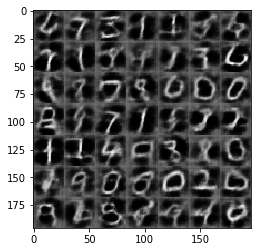

Epoch 0/2 Discriminator loss 1.1940 Generator loss 0.6808
Epoch 0/2 Discriminator loss 0.9498 Generator loss 1.0004
Epoch 0/2 Discriminator loss 0.8663 Generator loss 1.7118
Epoch 0/2 Discriminator loss 0.8338 Generator loss 1.4261
Epoch 0/2 Discriminator loss 0.9982 Generator loss 2.2634
Epoch 0/2 Discriminator loss 0.8067 Generator loss 1.3266
Epoch 0/2 Discriminator loss 1.8297 Generator loss 0.3685
Epoch 0/2 Discriminator loss 0.9800 Generator loss 1.0230
Epoch 0/2 Discriminator loss 0.9511 Generator loss 1.4788
Epoch 0/2 Discriminator loss 0.8595 Generator loss 1.5940


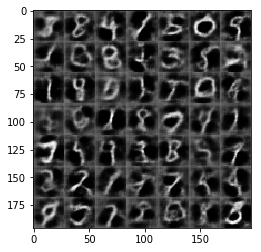

Epoch 0/2 Discriminator loss 0.8768 Generator loss 1.5402
Epoch 0/2 Discriminator loss 1.0605 Generator loss 0.8732
Epoch 0/2 Discriminator loss 0.8918 Generator loss 1.1419
Epoch 1/2 Discriminator loss 0.8617 Generator loss 1.3073
Epoch 1/2 Discriminator loss 0.6860 Generator loss 1.8995
Epoch 1/2 Discriminator loss 0.9038 Generator loss 1.8532
Epoch 1/2 Discriminator loss 0.9063 Generator loss 1.0601
Epoch 1/2 Discriminator loss 0.8289 Generator loss 1.2995
Epoch 1/2 Discriminator loss 0.7356 Generator loss 2.1764
Epoch 1/2 Discriminator loss 0.8622 Generator loss 1.1003


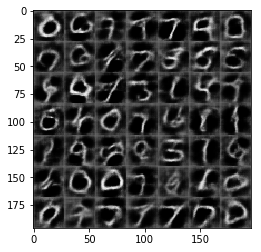

Epoch 1/2 Discriminator loss 2.2434 Generator loss 0.2317
Epoch 1/2 Discriminator loss 1.0232 Generator loss 0.9379
Epoch 1/2 Discriminator loss 0.9465 Generator loss 0.9906
Epoch 1/2 Discriminator loss 0.9549 Generator loss 0.9273
Epoch 1/2 Discriminator loss 0.9497 Generator loss 0.9316
Epoch 1/2 Discriminator loss 1.0891 Generator loss 0.7845
Epoch 1/2 Discriminator loss 0.9605 Generator loss 1.0796
Epoch 1/2 Discriminator loss 0.9751 Generator loss 0.9604
Epoch 1/2 Discriminator loss 0.8259 Generator loss 1.2922
Epoch 1/2 Discriminator loss 1.1126 Generator loss 0.7502


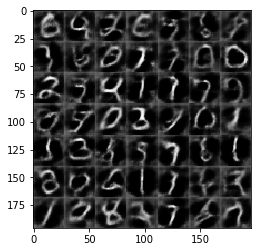

Epoch 1/2 Discriminator loss 0.8795 Generator loss 1.1505
Epoch 1/2 Discriminator loss 0.9155 Generator loss 1.0061
Epoch 1/2 Discriminator loss 0.7355 Generator loss 1.3448
Epoch 1/2 Discriminator loss 1.0522 Generator loss 3.5236
Epoch 1/2 Discriminator loss 1.0361 Generator loss 1.2345
Epoch 1/2 Discriminator loss 0.7076 Generator loss 1.5481
Epoch 1/2 Discriminator loss 0.8432 Generator loss 1.3105
Epoch 1/2 Discriminator loss 1.2309 Generator loss 0.6209
Epoch 1/2 Discriminator loss 0.9230 Generator loss 1.6293
Epoch 1/2 Discriminator loss 0.8935 Generator loss 1.1686


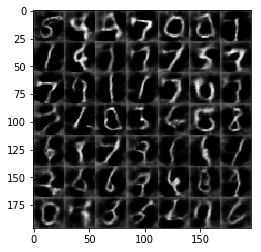

Epoch 1/2 Discriminator loss 0.6822 Generator loss 1.7124
Epoch 1/2 Discriminator loss 1.0955 Generator loss 0.7567
Epoch 1/2 Discriminator loss 0.9344 Generator loss 1.7296
Epoch 1/2 Discriminator loss 0.9301 Generator loss 0.9538
Epoch 1/2 Discriminator loss 0.8954 Generator loss 1.0468
Epoch 1/2 Discriminator loss 2.0150 Generator loss 0.2682
Epoch 1/2 Discriminator loss 0.9887 Generator loss 0.9472
Epoch 1/2 Discriminator loss 0.8658 Generator loss 1.2569
Epoch 1/2 Discriminator loss 0.6783 Generator loss 1.4620
Epoch 1/2 Discriminator loss 0.7844 Generator loss 1.2115


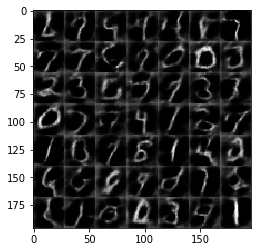

Epoch 1/2 Discriminator loss 0.7939 Generator loss 2.2036
Epoch 1/2 Discriminator loss 1.1243 Generator loss 0.8658
Epoch 1/2 Discriminator loss 0.8279 Generator loss 1.2673
Epoch 1/2 Discriminator loss 0.9515 Generator loss 1.0129
Epoch 1/2 Discriminator loss 0.9148 Generator loss 0.9600
Epoch 1/2 Discriminator loss 0.6744 Generator loss 1.9639
Epoch 1/2 Discriminator loss 0.7649 Generator loss 1.3091
Epoch 1/2 Discriminator loss 1.0829 Generator loss 0.8265
Epoch 1/2 Discriminator loss 0.6376 Generator loss 1.6731
Epoch 1/2 Discriminator loss 1.1877 Generator loss 0.6564


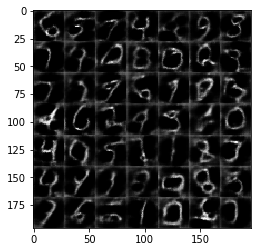

Epoch 1/2 Discriminator loss 0.8371 Generator loss 1.6616
Epoch 1/2 Discriminator loss 0.9776 Generator loss 1.0065
Epoch 1/2 Discriminator loss 0.9348 Generator loss 0.9960
Epoch 1/2 Discriminator loss 0.8165 Generator loss 1.2217
Epoch 1/2 Discriminator loss 1.1321 Generator loss 0.7551
Epoch 1/2 Discriminator loss 1.2115 Generator loss 0.6601
Epoch 1/2 Discriminator loss 0.9921 Generator loss 0.8970
Epoch 1/2 Discriminator loss 0.9334 Generator loss 1.1298
Epoch 1/2 Discriminator loss 0.7761 Generator loss 1.3259
Epoch 1/2 Discriminator loss 0.6310 Generator loss 1.7703


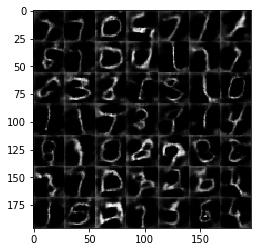

Epoch 1/2 Discriminator loss 1.1921 Generator loss 0.6732
Epoch 1/2 Discriminator loss 0.9645 Generator loss 0.9120
Epoch 1/2 Discriminator loss 0.8794 Generator loss 1.0932
Epoch 1/2 Discriminator loss 0.7332 Generator loss 2.0641
Epoch 1/2 Discriminator loss 0.6702 Generator loss 1.4500
Epoch 1/2 Discriminator loss 0.8143 Generator loss 1.1818
Epoch 1/2 Discriminator loss 0.7161 Generator loss 1.4259
Epoch 1/2 Discriminator loss 0.7562 Generator loss 1.2997
Epoch 1/2 Discriminator loss 0.6101 Generator loss 1.6953
Epoch 1/2 Discriminator loss 0.8941 Generator loss 2.3621


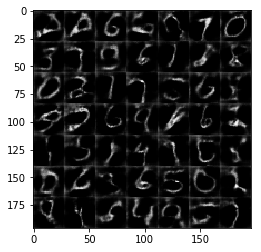

Epoch 1/2 Discriminator loss 1.3421 Generator loss 0.5519
Epoch 1/2 Discriminator loss 0.7552 Generator loss 1.6746
Epoch 1/2 Discriminator loss 1.0180 Generator loss 0.9245
Epoch 1/2 Discriminator loss 0.6430 Generator loss 1.8435
Epoch 1/2 Discriminator loss 0.6577 Generator loss 1.7946
Epoch 1/2 Discriminator loss 0.8523 Generator loss 1.0708
Epoch 1/2 Discriminator loss 0.7371 Generator loss 1.3909
Epoch 1/2 Discriminator loss 1.0301 Generator loss 0.8754
Epoch 1/2 Discriminator loss 2.3322 Generator loss 3.9451
Epoch 1/2 Discriminator loss 0.8917 Generator loss 1.5248


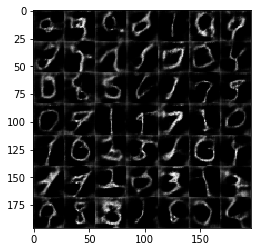

Epoch 1/2 Discriminator loss 0.8116 Generator loss 2.2043
Epoch 1/2 Discriminator loss 0.6694 Generator loss 1.7558
Epoch 1/2 Discriminator loss 0.9669 Generator loss 1.0232
Epoch 1/2 Discriminator loss 1.0090 Generator loss 0.8457
Epoch 1/2 Discriminator loss 0.7170 Generator loss 2.2333
Epoch 1/2 Discriminator loss 1.2413 Generator loss 0.6925
Epoch 1/2 Discriminator loss 0.8042 Generator loss 2.1233
Epoch 1/2 Discriminator loss 0.7009 Generator loss 1.6124
Epoch 1/2 Discriminator loss 0.8051 Generator loss 1.2015
Epoch 1/2 Discriminator loss 0.7040 Generator loss 2.0773


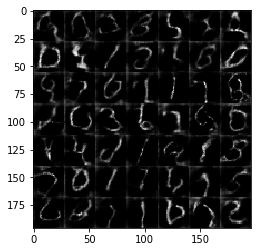

Epoch 1/2 Discriminator loss 1.3172 Generator loss 0.6592
Epoch 1/2 Discriminator loss 0.7266 Generator loss 1.4468
Epoch 1/2 Discriminator loss 0.5985 Generator loss 2.2158
Epoch 1/2 Discriminator loss 0.7408 Generator loss 1.3207
Epoch 1/2 Discriminator loss 0.7047 Generator loss 1.4943
Epoch 1/2 Discriminator loss 1.2074 Generator loss 0.7092
Epoch 1/2 Discriminator loss 0.8738 Generator loss 1.2240


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 0/1 Discriminator loss 0.7324 Generator loss 12.3955
Epoch 0/1 Discriminator loss 0.8096 Generator loss 1.8214
Epoch 0/1 Discriminator loss 3.4052 Generator loss 0.0638
Epoch 0/1 Discriminator loss 1.2459 Generator loss 8.8343
Epoch 0/1 Discriminator loss 0.8906 Generator loss 2.0628
Epoch 0/1 Discriminator loss 0.7778 Generator loss 2.6949
Epoch 0/1 Discriminator loss 0.5836 Generator loss 3.2250
Epoch 0/1 Discriminator loss 0.7208 Generator loss 2.9682
Epoch 0/1 Discriminator loss 1.0218 Generator loss 4.0419
Epoch 0/1 Discriminator loss 0.5458 Generator loss 2.2820


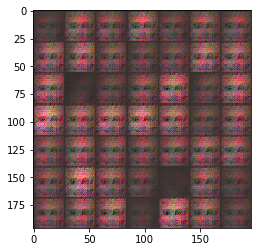

Epoch 0/1 Discriminator loss 0.8917 Generator loss 4.8885
Epoch 0/1 Discriminator loss 0.6661 Generator loss 1.6166
Epoch 0/1 Discriminator loss 1.1184 Generator loss 0.8048
Epoch 0/1 Discriminator loss 0.7145 Generator loss 2.5748
Epoch 0/1 Discriminator loss 0.6571 Generator loss 2.4801
Epoch 0/1 Discriminator loss 1.4365 Generator loss 0.5068
Epoch 0/1 Discriminator loss 1.1764 Generator loss 1.9478
Epoch 0/1 Discriminator loss 1.1811 Generator loss 1.5633
Epoch 0/1 Discriminator loss 1.4060 Generator loss 1.6608
Epoch 0/1 Discriminator loss 0.7829 Generator loss 1.9370


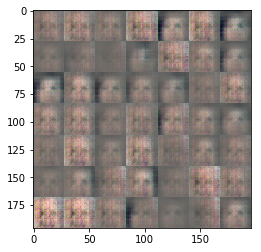

Epoch 0/1 Discriminator loss 0.8625 Generator loss 1.6218
Epoch 0/1 Discriminator loss 1.1404 Generator loss 0.9951
Epoch 0/1 Discriminator loss 0.8671 Generator loss 1.1346
Epoch 0/1 Discriminator loss 0.8972 Generator loss 0.9939
Epoch 0/1 Discriminator loss 1.6133 Generator loss 2.9042
Epoch 0/1 Discriminator loss 1.1034 Generator loss 0.8380
Epoch 0/1 Discriminator loss 1.1576 Generator loss 0.8204
Epoch 0/1 Discriminator loss 0.9866 Generator loss 1.1912
Epoch 0/1 Discriminator loss 0.9624 Generator loss 2.0267
Epoch 0/1 Discriminator loss 0.9609 Generator loss 1.1365


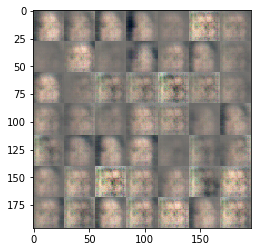

Epoch 0/1 Discriminator loss 1.0680 Generator loss 0.9138
Epoch 0/1 Discriminator loss 1.5512 Generator loss 0.5790
Epoch 0/1 Discriminator loss 1.0265 Generator loss 2.3293
Epoch 0/1 Discriminator loss 0.9859 Generator loss 1.3922
Epoch 0/1 Discriminator loss 0.9806 Generator loss 1.4269
Epoch 0/1 Discriminator loss 1.0641 Generator loss 1.0960
Epoch 0/1 Discriminator loss 1.2657 Generator loss 0.7277
Epoch 0/1 Discriminator loss 2.6876 Generator loss 3.9645
Epoch 0/1 Discriminator loss 1.1782 Generator loss 2.3798
Epoch 0/1 Discriminator loss 1.4372 Generator loss 0.9058


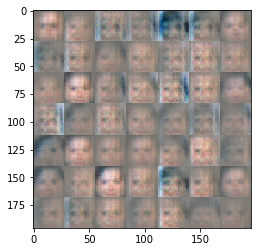

Epoch 0/1 Discriminator loss 1.0532 Generator loss 1.3272
Epoch 0/1 Discriminator loss 1.2411 Generator loss 1.8315
Epoch 0/1 Discriminator loss 1.0123 Generator loss 1.2039
Epoch 0/1 Discriminator loss 1.1354 Generator loss 0.7514
Epoch 0/1 Discriminator loss 0.9561 Generator loss 2.5331
Epoch 0/1 Discriminator loss 0.6332 Generator loss 1.8592
Epoch 0/1 Discriminator loss 0.8035 Generator loss 1.3743
Epoch 0/1 Discriminator loss 0.9115 Generator loss 1.3279
Epoch 0/1 Discriminator loss 0.9780 Generator loss 1.1290
Epoch 0/1 Discriminator loss 1.4925 Generator loss 2.9492


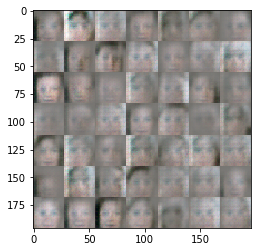

Epoch 0/1 Discriminator loss 1.1807 Generator loss 1.5967
Epoch 0/1 Discriminator loss 1.1500 Generator loss 0.7918
Epoch 0/1 Discriminator loss 2.1710 Generator loss 0.2215
Epoch 0/1 Discriminator loss 0.9370 Generator loss 1.3136
Epoch 0/1 Discriminator loss 0.8821 Generator loss 1.3230
Epoch 0/1 Discriminator loss 1.0770 Generator loss 2.2606
Epoch 0/1 Discriminator loss 0.7942 Generator loss 1.2004
Epoch 0/1 Discriminator loss 0.6179 Generator loss 2.0714
Epoch 0/1 Discriminator loss 2.0237 Generator loss 0.2561
Epoch 0/1 Discriminator loss 0.9571 Generator loss 1.1805


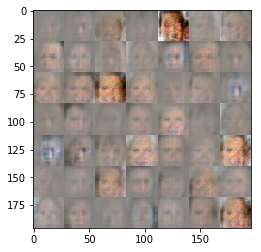

Epoch 0/1 Discriminator loss 1.9826 Generator loss 3.3732
Epoch 0/1 Discriminator loss 0.8318 Generator loss 2.2436
Epoch 0/1 Discriminator loss 1.2403 Generator loss 1.0072
Epoch 0/1 Discriminator loss 1.4769 Generator loss 3.0413
Epoch 0/1 Discriminator loss 0.9840 Generator loss 1.1415
Epoch 0/1 Discriminator loss 0.9984 Generator loss 1.7910
Epoch 0/1 Discriminator loss 0.9042 Generator loss 1.7666
Epoch 0/1 Discriminator loss 0.8276 Generator loss 2.5160
Epoch 0/1 Discriminator loss 1.0014 Generator loss 0.9816
Epoch 0/1 Discriminator loss 1.1385 Generator loss 0.8889


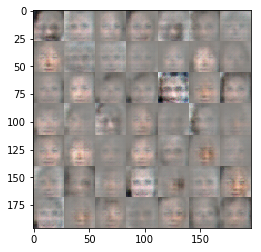

Epoch 0/1 Discriminator loss 0.9662 Generator loss 1.0685
Epoch 0/1 Discriminator loss 0.8191 Generator loss 1.5330
Epoch 0/1 Discriminator loss 1.5096 Generator loss 0.4866
Epoch 0/1 Discriminator loss 0.8918 Generator loss 2.3514
Epoch 0/1 Discriminator loss 1.2684 Generator loss 0.7412
Epoch 0/1 Discriminator loss 1.1686 Generator loss 0.7275
Epoch 0/1 Discriminator loss 0.9110 Generator loss 1.1842
Epoch 0/1 Discriminator loss 0.7690 Generator loss 1.4467
Epoch 0/1 Discriminator loss 0.8285 Generator loss 2.2969
Epoch 0/1 Discriminator loss 1.1361 Generator loss 1.9195


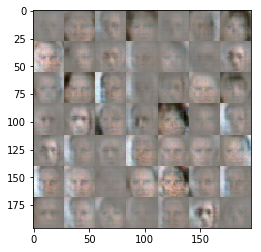

Epoch 0/1 Discriminator loss 0.8617 Generator loss 1.4521
Epoch 0/1 Discriminator loss 1.0285 Generator loss 1.0252
Epoch 0/1 Discriminator loss 0.8587 Generator loss 1.6734
Epoch 0/1 Discriminator loss 1.0029 Generator loss 0.9449
Epoch 0/1 Discriminator loss 0.8012 Generator loss 1.4845
Epoch 0/1 Discriminator loss 1.0822 Generator loss 0.9886
Epoch 0/1 Discriminator loss 1.0551 Generator loss 1.0572
Epoch 0/1 Discriminator loss 0.9020 Generator loss 1.4457
Epoch 0/1 Discriminator loss 1.0930 Generator loss 0.9061
Epoch 0/1 Discriminator loss 1.3088 Generator loss 0.9059


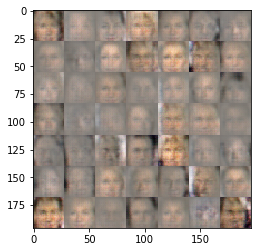

Epoch 0/1 Discriminator loss 1.2310 Generator loss 0.8175
Epoch 0/1 Discriminator loss 1.1800 Generator loss 1.3860
Epoch 0/1 Discriminator loss 1.0844 Generator loss 0.8013
Epoch 0/1 Discriminator loss 1.0213 Generator loss 0.9440
Epoch 0/1 Discriminator loss 0.7831 Generator loss 1.6212
Epoch 0/1 Discriminator loss 1.3298 Generator loss 0.6098
Epoch 0/1 Discriminator loss 0.9189 Generator loss 1.6253
Epoch 0/1 Discriminator loss 1.0862 Generator loss 1.2512
Epoch 0/1 Discriminator loss 1.0433 Generator loss 2.1479
Epoch 0/1 Discriminator loss 1.0661 Generator loss 0.9770


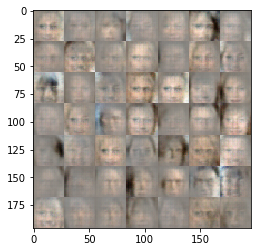

Epoch 0/1 Discriminator loss 0.7666 Generator loss 1.5715
Epoch 0/1 Discriminator loss 1.2049 Generator loss 0.6476
Epoch 0/1 Discriminator loss 1.0284 Generator loss 1.6208
Epoch 0/1 Discriminator loss 0.8953 Generator loss 1.0742
Epoch 0/1 Discriminator loss 0.9881 Generator loss 1.0347
Epoch 0/1 Discriminator loss 0.9009 Generator loss 1.1316
Epoch 0/1 Discriminator loss 0.9925 Generator loss 1.7945
Epoch 0/1 Discriminator loss 1.0871 Generator loss 2.2095
Epoch 0/1 Discriminator loss 1.2262 Generator loss 0.9455
Epoch 0/1 Discriminator loss 1.0894 Generator loss 0.8508


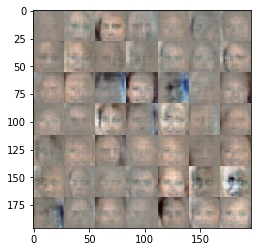

Epoch 0/1 Discriminator loss 0.8378 Generator loss 1.4864
Epoch 0/1 Discriminator loss 1.0745 Generator loss 1.3089
Epoch 0/1 Discriminator loss 1.2159 Generator loss 0.7352
Epoch 0/1 Discriminator loss 0.9074 Generator loss 1.3983
Epoch 0/1 Discriminator loss 1.1448 Generator loss 0.8301
Epoch 0/1 Discriminator loss 0.9031 Generator loss 1.6840
Epoch 0/1 Discriminator loss 1.6907 Generator loss 0.3949
Epoch 0/1 Discriminator loss 0.9123 Generator loss 2.3959
Epoch 0/1 Discriminator loss 0.8744 Generator loss 2.0510
Epoch 0/1 Discriminator loss 0.8890 Generator loss 1.2603


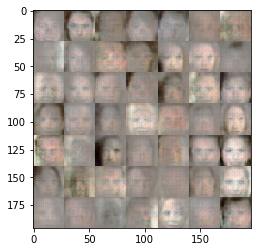

Epoch 0/1 Discriminator loss 1.2447 Generator loss 0.7451
Epoch 0/1 Discriminator loss 0.8899 Generator loss 1.7068
Epoch 0/1 Discriminator loss 0.9273 Generator loss 1.8565
Epoch 0/1 Discriminator loss 1.0157 Generator loss 0.9050
Epoch 0/1 Discriminator loss 1.1066 Generator loss 0.9365
Epoch 0/1 Discriminator loss 0.9656 Generator loss 1.1307
Epoch 0/1 Discriminator loss 0.7062 Generator loss 1.8189
Epoch 0/1 Discriminator loss 0.9753 Generator loss 1.3578
Epoch 0/1 Discriminator loss 1.1536 Generator loss 0.7728
Epoch 0/1 Discriminator loss 1.0818 Generator loss 1.0656


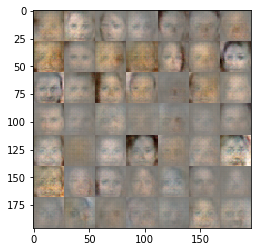

Epoch 0/1 Discriminator loss 0.8400 Generator loss 1.7120
Epoch 0/1 Discriminator loss 1.0048 Generator loss 1.2980
Epoch 0/1 Discriminator loss 1.1226 Generator loss 1.5982
Epoch 0/1 Discriminator loss 0.7644 Generator loss 1.5348
Epoch 0/1 Discriminator loss 0.9020 Generator loss 1.5610
Epoch 0/1 Discriminator loss 0.8673 Generator loss 1.2751
Epoch 0/1 Discriminator loss 0.9878 Generator loss 2.1245
Epoch 0/1 Discriminator loss 0.9861 Generator loss 2.2023
Epoch 0/1 Discriminator loss 1.0053 Generator loss 1.7591
Epoch 0/1 Discriminator loss 0.7570 Generator loss 1.4087


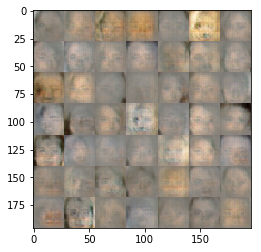

Epoch 0/1 Discriminator loss 1.4367 Generator loss 2.5835
Epoch 0/1 Discriminator loss 1.4530 Generator loss 0.5317
Epoch 0/1 Discriminator loss 0.8349 Generator loss 1.4540
Epoch 0/1 Discriminator loss 0.8212 Generator loss 1.4980
Epoch 0/1 Discriminator loss 1.4135 Generator loss 2.7175
Epoch 0/1 Discriminator loss 1.0184 Generator loss 1.0060
Epoch 0/1 Discriminator loss 0.8489 Generator loss 1.1492
Epoch 0/1 Discriminator loss 1.1731 Generator loss 0.7008
Epoch 0/1 Discriminator loss 1.3246 Generator loss 2.1836
Epoch 0/1 Discriminator loss 0.8971 Generator loss 1.5128


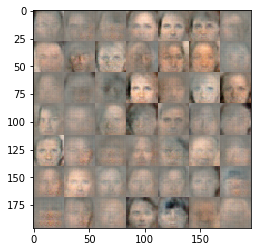

Epoch 0/1 Discriminator loss 1.1022 Generator loss 0.9203
Epoch 0/1 Discriminator loss 0.9339 Generator loss 1.4419
Epoch 0/1 Discriminator loss 0.9147 Generator loss 1.1045
Epoch 0/1 Discriminator loss 0.9709 Generator loss 1.0842
Epoch 0/1 Discriminator loss 1.0728 Generator loss 1.0573
Epoch 0/1 Discriminator loss 1.5190 Generator loss 0.4730
Epoch 0/1 Discriminator loss 1.0709 Generator loss 1.4114
Epoch 0/1 Discriminator loss 1.1575 Generator loss 2.7178


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.